In [0]:
!pip install tslearn

     |████████████████████████████████| 747kB 4.8MB/s 


In [0]:
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import to_time_series_dataset

from tslearn.metrics import cdist_dtw
from tslearn.clustering import silhouette_score

import csv
import matplotlib.pyplot as plt
import copy 




/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
###############################################################
# Clustering then Normalizing
#####################################################

In [0]:
#adding data
number_of_clusters = 4
# metricOfClustering = "dtw"
metricOfClustering = "euclidean"
title = 'Kona'

with open(title +'.csv','r') as dest_f:
    data_iter = csv.reader(dest_f,
                           #delimiter = delimiter,
                           quotechar = '"')
    full_data = np.array([np.array(i_data[:25]) for i_data in data_iter])
    full_data = full_data[1:]
datawithId = full_data[:, :23].astype(float)
data = datawithId[:, 3:23]
X = data[:].astype(float)
sz = X.shape[1]

############################################################################
# Transfoming data
arr_of_ind = []
for i, row in enumerate(X):
    if (sum(row < 7) + sum(row > 40)) > 10:
        arr_of_ind.append(i)

X = np.delete(X, arr_of_ind, axis=0)
datawithId = np.delete(datawithId, arr_of_ind, axis=0)

############################################################################
# Rolling avarage

def RollingAvarage2(array):
  copyOfArray = copy.deepcopy(array)
  for i,row in enumerate(array):
    for j,col in enumerate(row):
      if j==0:
        array[i][j] = (copyOfArray[i][j] + copyOfArray[i][j+1])/2
      elif j== len(row)-1:
        array[i][j] = (copyOfArray[i][j-1] + copyOfArray[i][j])/2
      else:
        array[i][j] = (copyOfArray[i][j-1] + copyOfArray[i][j] + copyOfArray[i][j+1])/3

  return array

X = RollingAvarage2(X)
datawithId[:,3:] = RollingAvarage2(datawithId[:,3:])

############################################################################
#Clustering

X_bis = to_time_series_dataset(X)
a = TimeSeriesKMeans(n_clusters=number_of_clusters, max_iter=5, metric= metricOfClustering, random_state=0)
b = a.fit_predict(X_bis)

############################################################################
#extracting ID array from clustered data

arrayofId =[]
clusteredArray = []

def check(test,array):
  result = any(np.array_equal(x, test) for x in array)
  return result


def extractIDArray(number_of_clusters,datawithId, X):
  for i in range(number_of_clusters):
    Id = [] 
    cluster =[]
    for rowInX in datawithId:
      if check(rowInX[2:].astype(float), X[np.where(b == i)]):
        print(rowInX)
        Id.append(int(rowInX[0]))
        cluster.append(rowInX[1:])
    arrayofId.insert(i,Id)
    clusteredArray.insert(i,cluster)
  
  return arrayofId, clusteredArray

arrayofId, clusteredArray = extractIDArray(number_of_clusters,datawithId[:,2:], X)

############################################################################

arrayofMeta = []
dictionary = {
    "age_group": "",
    "gender": ""
}

for sub_arr in arrayofId:
  length = len(sub_arr)
  inner_arr = np.array([])

  for elem in sub_arr:
    mask = full_data[:, 2] == str(elem)
    res = full_data[mask, [-1, -2]]
    inner_arr = np.append(inner_arr, res)
  
  
  inner_arr = inner_arr.reshape(-1, 2)
  unique_age, counts_age = np.unique(inner_arr[:, 0], return_counts=True)
  unique_gender, counts_gender = np.unique(inner_arr[:, 1], return_counts=True)

  age_desc_arr = np.asarray((unique_age, counts_age)).T
  gender_desc_arr = np.asarray((unique_gender, counts_gender)).T
  appended_gender_age = np.append(age_desc_arr, gender_desc_arr, axis=0)
  arrayofMeta.append(appended_gender_age)

############################################################################
# for normalizing clustered data

clusteredArrayCopy = np.copy(clusteredArray)

def getNorm(arr):
    for row in range(0, len(arr)):
        maximumVal = 0.0
        minimumVal = 0.0
        for column in range(0, len(arr[0])):

            if column == 1:
                minimumVal = arr[row][column]
            if float(arr[row][column]) >= maximumVal:
                maximumVal = arr[row][column]
            if float(arr[row][column]) < minimumVal:
                minimumVal = arr[row][column]

        for column in range(0, len(arr[0])):
            arr[row][column] = (arr[row][column] - minimumVal) / (maximumVal - minimumVal)
            arr[row][column] = round(arr[row][column], 2)

    return arr

normalizedClusteredArray = []

for i in range(0,number_of_clusters):
  normalizedClusteredArray.append(getNorm(clusteredArrayCopy[i])) 

############################################################################

normalizedClusterCenters = []

def getNorm1D(arr):
    max_value = np.max(arr)
    min_value = np.min(arr)

    for index in range(0, len(arr)):
      arr[index] = (arr[index] - min_value) / (max_value - min_value)
      arr[index] = round(arr[index], 2)

    return arr

for i in range(number_of_clusters):
  normalizedClusterCenters.append(getNorm1D(a.cluster_centers_[i].ravel()))

############################################################################

# normalizedClusteredArray = sorted(normalizedClusteredArray, key=lambda a: len(a), reverse=True)
def key_func(arr):
  sum = 0
  for pair_arr in arr:
    if pair_arr[0] == 'M' or pair_arr[0] == 'F':
      sum += int(pair_arr[1])
  return sum

# arrayofMeta = sorted(arrayofMeta, key=key_func, reverse=True)

############################################################################
# Ranks in clusters

arrayOfClusterRanks = []
mediumRankForClusters = []
for idArray in arrayofId:
  array = []
  for ID in idArray:
    for row in full_data:
      if ID == row[2].astype(int):
        array.append(row[0].astype(int))
  arrayOfClusterRanks.append(array)

for cluster in arrayOfClusterRanks:
    mediumRankForClusters.append(np.mean(cluster))

################################################################################
MaleNumber = 0
FemaleNumber = 0
percentOfMale = 0
percentOfFemale = 0

for index, meta in enumerate(arrayofMeta): 
  for part in meta:
    if(part[0] == 'F'):
      FemaleNumber = FemaleNumber + meta[len(meta)-2][1].astype(int)
    if(part[0] == 'M'):
        MaleNumber = MaleNumber + meta[len(meta)-1][1].astype(int)

arrayOfPercentage = []

for index, meta in enumerate(arrayofMeta): 
  array = []

  for part in meta:
    if(part[0] == 'F'):
      percentOfFemale = (meta[len(meta)-2][1].astype(int))/FemaleNumber
      female = []
      female.append('F')
      female.append(percentOfFemale*100)
      array.append(female)
    if(part[0] == 'M'):
      male = [] 
      percentOfMale = (meta[len(meta)-1][1].astype(int))/MaleNumber
      male.append('M')
      male.append(percentOfMale*100)
      array.append(male)
       
  arrayOfPercentage.append(array) 
##############################################################################

full_Id_List = []
for array in arrayofId:
  for id in array:
    full_Id_List.append(id)

inner_array = np.array([])
for ID in full_Id_List:
  maskValue = full_data[:, 2] == str(ID)
  resValue = full_data[maskValue, [-1, -1]]
  inner_array = np.append(inner_array, resValue)

inner_Value = inner_array.reshape(-1, 2)
unique_ages, counts_ages = np.unique(inner_Value[:, -2], return_counts=True)
# print(unique_ages,counts_ages)


#######################################################################
percentageOfAgeGroups = []
for age, count in zip(unique_ages, counts_ages):
  array =[]
  for cluster in arrayofMeta:
    for inner in cluster:
      if inner[0] == age:
        result = str(round((inner[1].astype(int) / count)*100,2)) + '%'
        array.append(result)
  percentageOfAgeGroups.append(array)



[['0' '1' '1801334' '11.69' '11.69' '10.15' '14.77' '13.85' '19.38'
  '18.46' '0' '16.92' '23.08' '25.54' '5.54' '1.54' '9.23' '7.69' '4'
  '10.77' '8.62' '6.15' '2.46' 'M' '0_19']
 ['1' '2' '17770854' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0.77'
  '0' '1.54' '0.77' '4.62' '0.77' '1.54' '0.77' '0.77' 'M' '0_19']
 ['2' '4' '24841551' '0' '4.62' '4.62' '2.31' '11.54' '4.62' '3.08'
  '6.15' '10.77' '5.38' '2.31' '1.54' '9.23' '0' '2.31' '1.54' '1.54'
  '4.62' '1.54' '0' 'M' '0_19']
 ['3' '5' '28806053' '0' '3.77' '0' '0' '0' '0' '3.23' '23.69' '25.31'
  '39.31' '12.92' '49' '51.69' '22.08' '16.69' '7' '23.69' '16.69' '5.92'
  '4.85' 'M' '0_19']
 ['4' '6' '5030217' '3.12' '9.23' '0' '0' '2.31' '5.42' '0' '0' '1.5' '0'
  '0' '0' '0.81' '0' '0' '6.12' '6.12' '6.92' '6.92' '5.42' 'M' '0_19']
 ['5' '7' '15217952' '0' '0' '0' '16.08' '0' '0' '0' '0' '0' '0' '16.08'
  '0' '16.08' '16.08' '16.08' '16.08' '16.08' '16.08' '16.08' '16.08' 'M'
  '0_19']]
[[       0        1  1801334       11   

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
############################################
####silhouette####

silhouette_score(X_bis, b, metric="euclidean")

0.2769920764666117

In [0]:
###############################################################
# End of Block
#####################################################

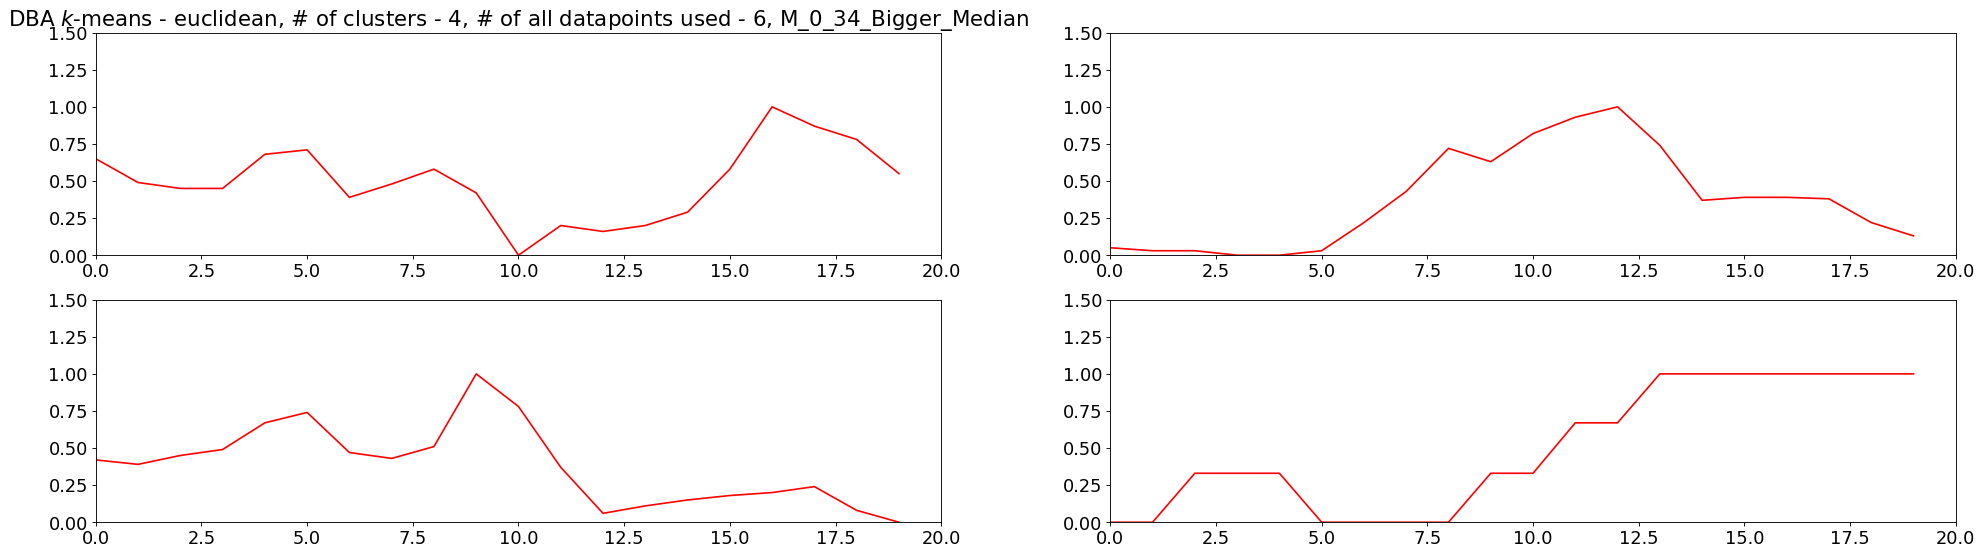

In [0]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 70), dpi=80, facecolor='w', edgecolor='k')
plt.rc('font', size=16)  

for yi in range(number_of_clusters):
    plt.subplot(16, 2, 1 + yi)
    for xx in clusteredArray[yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(a.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 1.5)
    ### Ranks
    # plt.text(0.75, 0.9,  'Mean of Ranks %d' % (mediumRankForClusters[yi]),transform=plt.gca().transAxes)
    ### Gender Percentages
    for index,part in enumerate(arrayOfPercentage[yi]):
      plt.text(0.5 +(index*0.2), 0.75,  '{} : {}{}'.format(part[0], round(part[1].astype(float),2), '%'), transform=plt.gca().transAxes)
    ### Age Percentages
    for index,age in enumerate(unique_ages):
      plt.text((index*0.2), 0.75,  '{} : {}'.format(age, percentageOfAgeGroups[index][yi]), transform=plt.gca().transAxes)

    ### Gender and Age numbers
    for index, meta in enumerate(arrayofMeta[yi]):
      plt.text(0.15 * index, 0.9, '{} : {} {}'.format(meta[0], meta[1],'|'), #'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
         plt.title("DBA $k$-means - " + metricOfClustering + ", # of clusters - " + str(number_of_clusters) + ", # of all datapoints used - " + str(len(X)) + ", M_0_34_Bigger_Median")